In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import sys
from iminuit import Minuit
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import os
from scipy.interpolate import interp1d
from scipy.interpolate import PchipInterpolator, InterpolatedUnivariateSpline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [3]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, simpson38
from ExternalFunctions import nice_string_output, add_text_to_ax 

In [4]:
COLOUR = ['#1E90FF', # 0 # Dodgerblue
          '#FFBF00', # 1 # Amber
          '#FF6347', # 2 # Tomato
          '#00A86B', # 3 # Jade
          '#8A2BE2', # 4 # Blueviolet
          '#FF6FFF', # 5 # Ultra Pink
          '#00CCFF', # 6 # Vivid Sky Blue
          '#00ff40', # 7 # Erin
          '#FF004F', # 8 # Folly
          '#0063A6', # 9 # Lapis Lazuli
        ]
def setMplParam(classNum):
    # Define effective colors, line styles, and markers based on the class number
   
    LINE = ['-', '-.', '--', '-.', ':','--','-.','-', ':', '--']
    MARKER = ['.','*', '^', 's', '.', 'p', 'o', 's', '.', 'd']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]

    # Set the color cycle for lines including color, line style, and marker
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                       plt.cycler(linestyle=LINE_EFF)+
                                       plt.cycler(marker=MARKER_EFF))

    # Set default line and marker sizes
    plt.rcParams['lines.markersize'] = 3  # Example size
    plt.rcParams['lines.linewidth'] = 2   # Example width for lines

    # Set label and title sizes
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    # Set tick properties
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20

    # Set legend font size
    plt.rcParams['legend.fontsize'] = 12

    # Enable and configure grid
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    # Set axes line width
    plt.rcParams['axes.linewidth'] = 2

    # Set tick sizes and widths
    plt.rcParams['xtick.major.size'] = 7
    plt.rcParams['xtick.major.width'] = 3
    plt.rcParams['xtick.minor.size'] = 2
    plt.rcParams['xtick.minor.width'] = 2

    plt.rcParams['ytick.major.size'] = 7
    plt.rcParams['ytick.major.width'] = 3
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['ytick.minor.width'] = 2

setMplParam(10)


In [5]:
def getdata():
    data =  np.array([
       [ 203.41 ,  -89.37 ],
       [ 203.435,  -94.88 ],
       [ 203.46 , -101.25 ],
       [ 203.484, -106.52 ],
       [ 203.509, -108.66 ],
       [ 203.534, -114.25 ],
       [ 203.558, -114.30 ],
       [ 203.583, -117.66 ],
       [ 203.608, -122.45 ]])
    sol = data[:,0]
    temperature = data[:,1]
    return sol, temperature

sol, temperature = getdata()

In [6]:
print (sol)
print (temperature)

[203.41  203.435 203.46  203.484 203.509 203.534 203.558 203.583 203.608]
[ -89.37  -94.88 -101.25 -106.52 -108.66 -114.25 -114.3  -117.66 -122.45]


In [7]:
# linearSpline = spline = interp1d(sol, temperature, kind='linear')
linearSpline = InterpolatedUnivariateSpline(sol, temperature, k=1)

cubicSpline = spline = interp1d(sol, temperature, kind='cubic')
# cubicSpline = PchipInterpolator(sol, temperature)

In [8]:
def plotSpline(sol, temperature, spline, title):
    sol_spl = np.linspace(sol[0], sol[-1], 1000)
    temperature_spl = spline(sol_spl)
    valueAt203_570 = spline(203.570)
    
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.plot(sol, temperature, 'o', label='Data', markersize=7)
    ax.plot(sol_spl, temperature_spl, label=title+' spline', marker='', linestyle='-')
    ax.plot(203.570, valueAt203_570, 'o', label=f'f(203.570) = {valueAt203_570:.3f}', markersize=7)
    ax.axvline(203.570, color=COLOUR[2], linestyle='--')
    ax.set_xlabel('Sol')
    ax.set_ylabel('Temperature')
    ax.set_title(title+' spline interpolation')
    ax.legend()

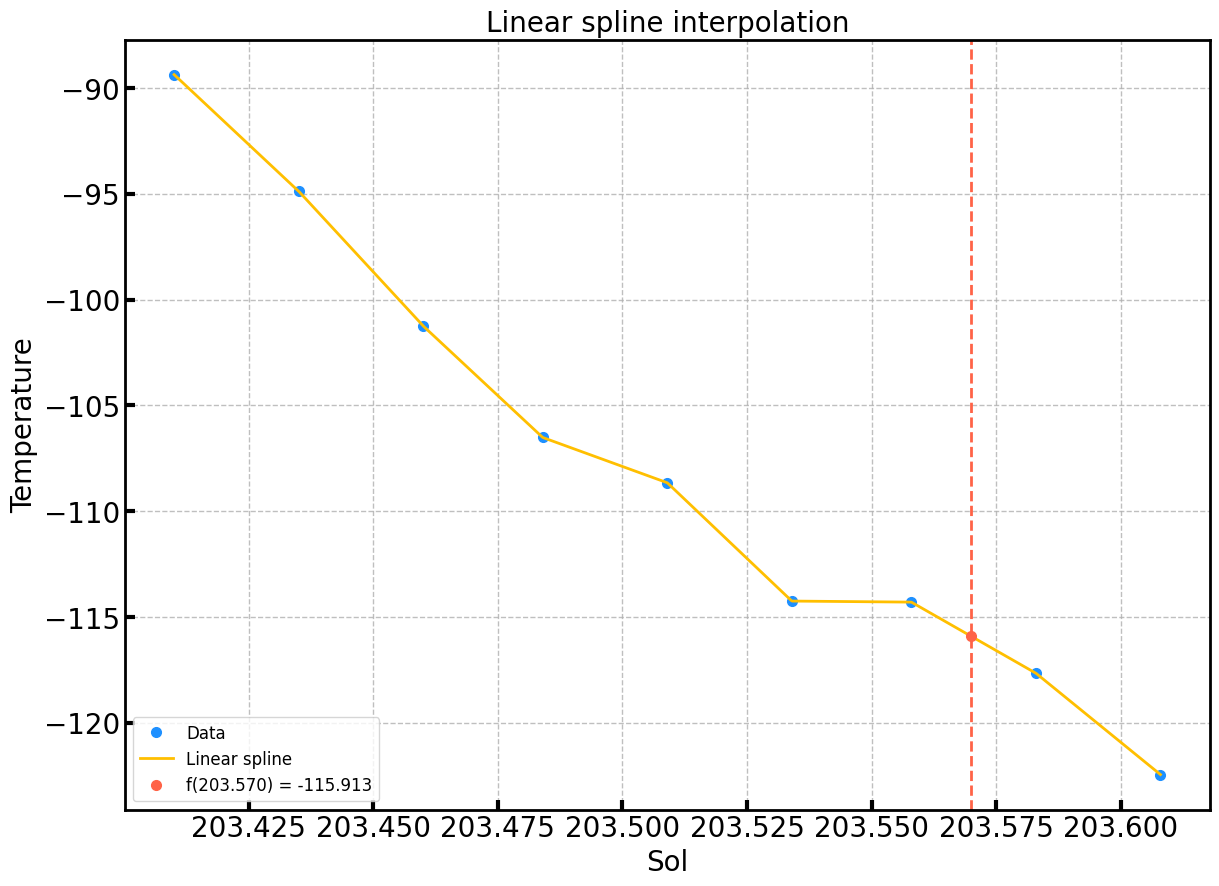

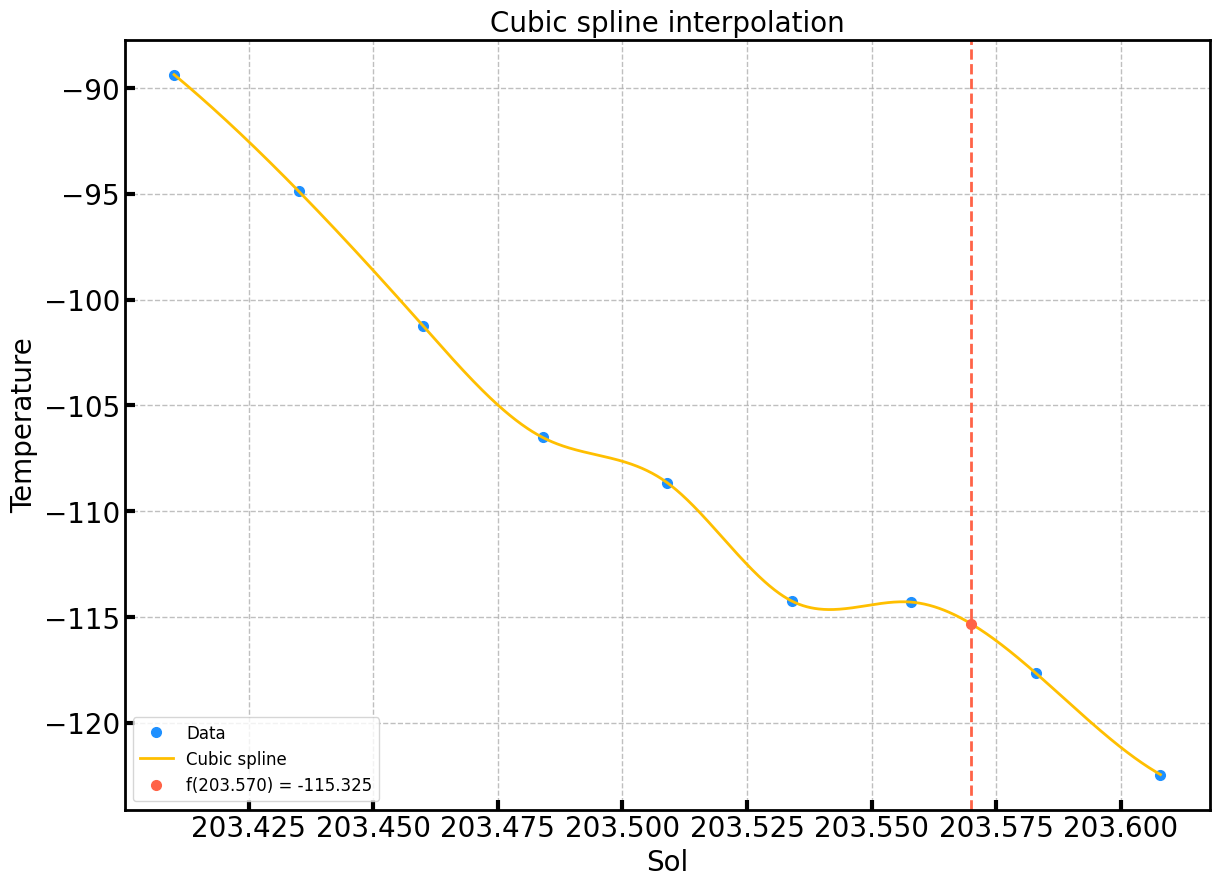

In [9]:
plotSpline(sol, temperature, linearSpline, 'Linear')
plotSpline(sol, temperature, cubicSpline, 'Cubic')

In [10]:
def findIncreasingIntervals(spline, sol_min, sol_max):
    N = 1000
    sol_points = np.linspace(sol_min, sol_max, N)
    temperature_points = spline(sol_points)
    derivative = np.gradient(temperature_points, sol_points)
    
    increasing_intervals = []
    start_increasing = None

    for i in range(len(sol_points)-1):
        if derivative[i] <= 0 and derivative[i+1] > 0:
            start_increasing = sol_points[i+1]
        elif derivative[i] > 0 and derivative[i+1] <= 0 and start_increasing is not None:
            increasing_intervals.append((start_increasing, sol_points[i]))
            start_increasing = None

    if start_increasing is not None:
        increasing_intervals.append((start_increasing, sol_points[-1]))

    return increasing_intervals


In [11]:
def plotScatterSpline(linearSpline, cubicSpline):
    sol_min = 203.410 
    sol_max = 203.608
    sol_spl = np.linspace(sol_min, sol_max, 1000)
    temperature_spl_linear = linearSpline(sol_spl)
    temperature_spl_cubic = cubicSpline(sol_spl)

    increasing_intervals_linear = findIncreasingIntervals(linearSpline, sol_min, sol_max)
    increasing_intervals_cubic = findIncreasingIntervals(cubicSpline, sol_min, sol_max)

    fig, ax = plt.subplots(figsize=(14, 10))
    ax.scatter(sol_spl, temperature_spl_linear, label='Linear spline', s=10, marker = '.')
    ax.scatter(sol_spl, temperature_spl_cubic, label='Cubic spline', s=10, marker = '.')
    ax.scatter(sol, temperature, label='Data', s=50)

    for interval in increasing_intervals_linear:
        ax.axvspan(interval[0], interval[1], color=COLOUR[3], alpha=0.2)
    for interval in increasing_intervals_cubic:
        ax.axvspan(interval[0], interval[1], color=COLOUR[4], alpha=0.2, label='Increasing interval')

    ax.set_xlabel('Sol')
    ax.set_ylabel('Temperature')
    ax.set_title('Spline interpolation scatter')
    ax.legend()
    d = {
        'interval bottom': interval[0],
        'interval top': interval[1],
    }
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.40, 0.75, text, ax, fontsize=12)

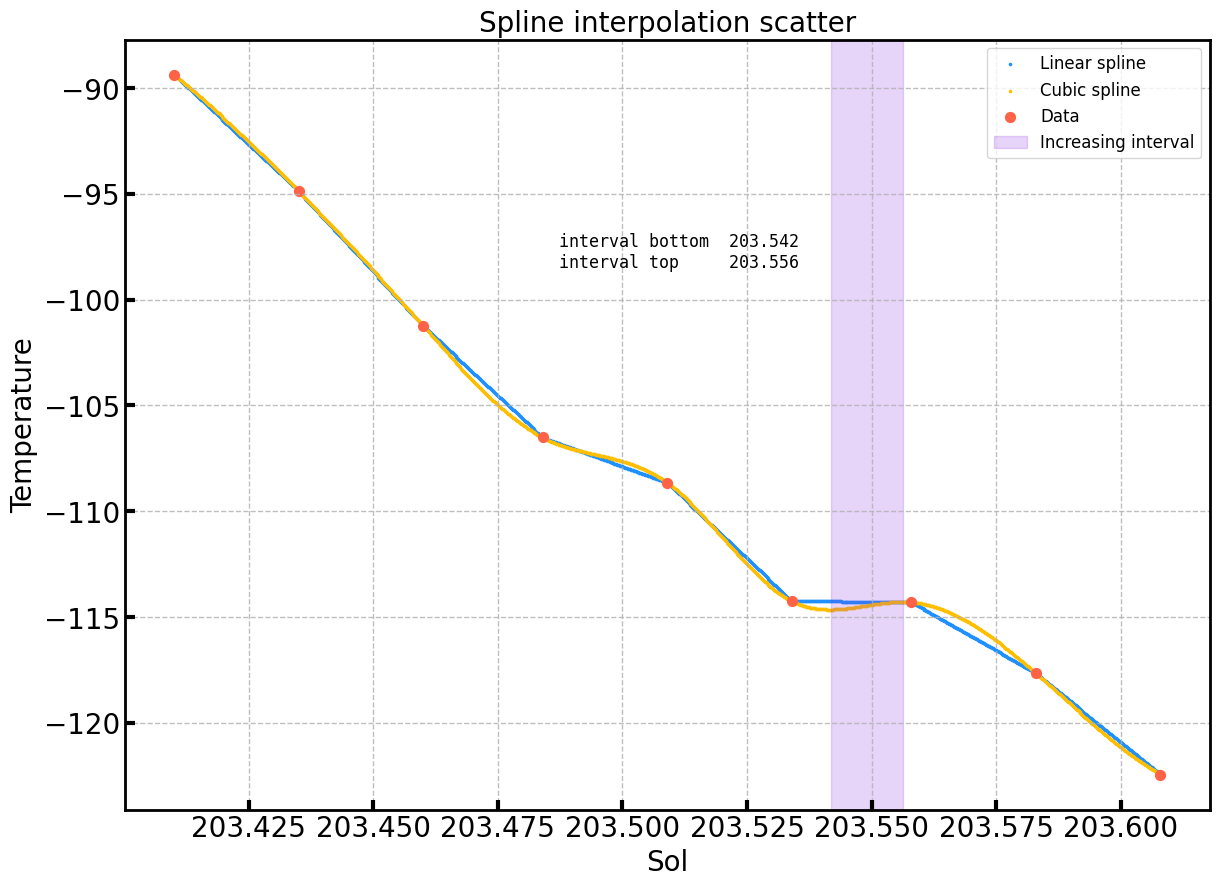

In [12]:
plotScatterSpline(linearSpline, cubicSpline)

In [13]:
def printSummaryInLatex(isSustainable_linear, isSustainable_cubic, max_rate_linear, max_rate_cubic, threshold_with_uncertainty):
    sustainability_linear = 'Yes' if isSustainable_linear else 'No'
    sustainability_cubic = 'Yes' if isSustainable_cubic else 'No'
    
    latex_str = """
    \\begin{{table}}[H]
    \\centering
    \\begin{{tabular}}{{|l|c|c|}}
    \\hline
    \\textbf{{Spline Type}} & \\textbf{{Max Rate of Change (°C per sol)}} & \\textbf{{Sustainable}} \\\\ \\hline
    Linear & {:.2f} & {} \\\\ \\hline
    Cubic & {:.2f} & {} \\\\ \\hline
    \\end{{tabular}}
    \\caption{{Temperature Change Sustainability with Threshold of {:.2f} °C per sol}}
    \\end{{table}}
    """.format(max_rate_linear, sustainability_linear, max_rate_cubic, sustainability_cubic, threshold_with_uncertainty)
    
    print(latex_str)


In [14]:
def checkTemperatureChange(linearSpline, cubicSpline):
    sol_points = np.linspace(sol.min(), sol.max(), 10000)
    
    linear_derivative = linearSpline.derivative()(sol_points)
    max_rate_linear = np.max(np.abs(linear_derivative))
    
    cubic_temperature = cubicSpline(sol_points)
    spacing = (sol_points.max() - sol_points.min()) / (len(sol_points) - 1)
    cubic_derivative = np.gradient(cubic_temperature, spacing)
    max_rate_cubic = np.max(np.abs(cubic_derivative))
    
    threshold = 0.09 / 0.0004  # °C per sol
    uncertainty = 0.001 / 0.0004  # °C per sol
    
    isSustainable_linear = max_rate_linear <= (threshold + uncertainty)
    isSustainable_cubic = max_rate_cubic <= (threshold + uncertainty)
    
    print(f"Linear spline sustainable: {'Yes' if isSustainable_linear else 'No'}")
    print(f"Cubic spline sustainable: {'Yes' if isSustainable_cubic else 'No'}")
    print(f"Threshold rate of change (with uncertainty): {threshold + uncertainty:.2f} °C per sol")
    print(f"Max rate of change - Linear: {max_rate_linear:.2f} °C per sol")
    print(f"Max rate of change - Cubic: {max_rate_cubic:.2f} °C per sol")

    printSummaryInLatex(isSustainable_linear, isSustainable_cubic, max_rate_linear, max_rate_cubic, threshold + uncertainty)

checkTemperatureChange(linearSpline, cubicSpline)


Linear spline sustainable: No
Cubic spline sustainable: No
Threshold rate of change (with uncertainty): 227.50 °C per sol
Max rate of change - Linear: 254.80 °C per sol
Max rate of change - Cubic: 265.64 °C per sol

    \begin{table}[H]
    \centering
    \begin{tabular}{|l|c|c|}
    \hline
    \textbf{Spline Type} & \textbf{Max Rate of Change (°C per sol)} & \textbf{Sustainable} \\ \hline
    Linear & 254.80 & No \\ \hline
    Cubic & 265.64 & No \\ \hline
    \end{tabular}
    \caption{Temperature Change Sustainability with Threshold of 227.50 °C per sol}
    \end{table}
    
